In [ ]:
%pip install langchain langchain-community langchain-groq langchain-google-genai pypdf chromadb langchain-chroma langgraph

In [28]:
from langgraph.graph import StateGraph, END
from langgraph.graph.message import add_messages
from langgraph.checkpoint.memory import MemorySaver
from typing_extensions import TypedDict
from typing import Annotated, Sequence, Literal
from langchain_core.messages import BaseMessage, AIMessage, HumanMessage
from langchain_google_genai import ChatGoogleGenerativeAI, GoogleGenerativeAIEmbeddings
from langchain_community.document_loaders import PyPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import Chroma
from langgraph.prebuilt import ToolNode, tools_condition
from langchain import hub
from langchain_core.output_parsers import StrOutputParser

In [11]:
from langchain_core.tools.base import BaseTool
from langchain_core.language_models.chat_models import BaseChatModel

In [3]:
from google.colab import userdata

GOOGLE_API_KEY = userdata.get("GOOGLE_API_KEY")

PDF_PATH = "/content/random_person_bio.pdf"
DB_PATH = "/checkpoints/db"

In [7]:
memory = MemorySaver()
config = {"configurable": {"thread_id": "1"}}
llm = ChatGoogleGenerativeAI(model="gemini-1.5-pro", google_api_key=GOOGLE_API_KEY)
embeddings = GoogleGenerativeAIEmbeddings(model="models/text-embedding-004", google_api_key=GOOGLE_API_KEY)

In [5]:
class AgentState(TypedDict):
  messages: Annotated[list[BaseMessage], add_messages]

In [8]:
loader = PyPDFLoader(PDF_PATH)
splitter = RecursiveCharacterTextSplitter(chunk_size = 256, chunk_overlap = 50)
docs_split = loader.load_and_split(text_splitter=splitter)

vectorstore = Chroma.from_documents(
    documents=docs_split,
    collection_name="rag-chroma",
    embedding=embeddings,
    persist_directory=DB_PATH
)

retriever = vectorstore.as_retriever()

In [9]:
from langchain.tools.retriever import create_retriever_tool

retriever_tool = create_retriever_tool(
    retriever=retriever,
    name="retrieve_data_document",
    description="Search and return information asked from the provided document",
)

tools = [retriever_tool]

In [19]:
%pip install ipython

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 64.8 MB/s eta 0:00:00


In [25]:
from IPython.display import Image, display

class RagAgent:

    def __init__(self, model: BaseChatModel, tools: list[BaseTool], system: str=""):
        self.system = system
        retriever = ToolNode(tools)
        self.model = model
        self.model_with_tools = model.bind_tools(tools)

        # Graph configurations
        graph = StateGraph(AgentState)

        # Graph nodes configuration
        graph.add_node("agent", self.agent)
        graph.add_node("retriever", retriever)
        graph.add_node("generate", self.generate)

        # Add edges
        graph.set_entry_point("agent")
        # graph.add_edge("agent", "retriever")
        graph.add_edge("retriever", "generate")
        graph.set_finish_point("generate")

        # Add conditional edges
        graph.add_conditional_edges(
            "agent",
            tools_condition,
            {
                "tools": "retriever",
                END: END,
            },
        )

        self.graph = graph.compile(checkpointer=memory)
        display(Image(self.graph.get_graph(xray=True).draw_mermaid_png()))


    def agent(self, state: AgentState) -> AgentState:
        """
        Invokes the agent model to generate a response based on the current state.
        Given the question, it will decide to retrieve using the retriever tool, or simply end.

        Args:
            state (AgentState): The current state

        Returns:
            AgentState: The updated state with the agent response appended to messages
        """
        messages = state["messages"]
        response = self.model_with_tools.invoke(messages)
        return {"messages": [response]}


    def generate(self, state: AgentState) -> AgentState:
        """
        Generate answer based on the retrieved data.

        Args:
            state (AgentState): The current state

        Returns:
            AgentState: The updated state with re-phrased question
        """
        messages = state["messages"]
        question = messages[0].content
        last_message = messages[-1].content

        prompt = hub.pull("rlm/rag-prompt")

        rag_chain = prompt | self.model | StrOutputParser()

        response = rag_chain.invoke({"context": last_message, "question": question})
        return {"messages": [response]}

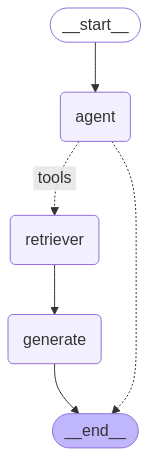

In [26]:
prompt = (
    "You are a Retrieval-Augmented Generation (RAG) agent designed to assist users by combining your internal reasoning with real-time, relevant information. "
    "When a question is presented, carefully analyze the query and determine if external data is necessary to form a complete answer. "
    "If additional context is needed, invoke the retriever tool to fetch the most relevant and current information, then integrate it with your internal knowledge. "
    "Your response should be accurate, well-organized, and delivered in a clear and professional tone. "
    "Always verify the relevance of the retrieved data and provide a comprehensive answer that directly addresses the user's query."
)

bot = RagAgent(llm, tools, system=prompt)

In [1]:
result = bot.graph.invoke({"messages": [HumanMessage (content="Who is Johnathan Reynolds")]}, config)
result["messages"]

NameError: name 'bot' is not defined